# Supervised Autoencoder on CIFAR-10 — Notebook

**Goal:** Train a supervised autoencoder (reconstruction + classification) on CIFAR-10

## Environment & Reproducibility



In [1]:
import os
import math
import random
from pathlib import Path
import numpy as np
import torch
import torchvision

## Config


In [2]:
from pprint import pprint

CONFIG = {
    # Data settings
    'seed'             : 42,
    'data_root'        : '../data',      # Path to dataset
    'num_classes'      : 10,             # CIFAR-10 → 10 classes
    'batch_size'       : 128,            # Samples per training batch
    'augment'          : True,           # Enable basic data augmentation (flips, crops, etc.)
    'num_workers'      : 4,              # Number of DataLoader workers
    'img_size'         : 64,             # Image resize dimension (height = width = 64)
    'split_train'      : 0.8,            # Train/validation split ratio (0.8 → 80% train, 20% val)

    # Model settings
    'latent_dim'       : 64,             # Latent vector dimension (e.g., 32, 64, 128)
    'loss_type'        : 'mse',          # Reconstruction loss: 'mse' (recommended) or 'bce'
    'lambda_recon'     : 50,             # Weight for reconstruction term (typical range: 0.1–50)
    'latent_noise_std' : 0.03,           # Std. dev. of Gaussian noise in latent space (train-time only)
                                         #   0.0  → deterministic encoder
                                         #   0.02–0.05 → mild smoothing (usually best)
                                         #   ≥0.1 → stronger noise, may reduce reconstruction accuracy
    'classifier_dropout': 0.25,          # Dropout rate for classifier head

    # Optimizer settings
    'lr'               : 3e-4,           # Learning rate (typical range: 1e-5 – 1e-3)
    'weight_decay'     : 5e-4,           # L2 regularization (weight decay)

    # Training settings
    'epochs'           : 40,             # Number of training epochs
}

pprint(CONFIG)

{'augment': True,
 'batch_size': 128,
 'classifier_dropout': 0.25,
 'data_root': '../data',
 'epochs': 40,
 'img_size': 64,
 'lambda_recon': 50,
 'latent_dim': 64,
 'latent_noise_std': 0.03,
 'loss_type': 'mse',
 'lr': 0.0003,
 'num_classes': 10,
 'num_workers': 4,
 'seed': 42,
 'split_train': 0.8,
 'weight_decay': 0.0005}


In [3]:
def set_seed(seed: int) -> None:
    """
    Set seeds for python, numpy, and torch (CPU and CUDA)
    to get reproducible behavior.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Data Pipeline (CIFAR-10)


In [4]:
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split  # random_split unused but kept

def get_transforms(augment: bool = True, resize_to: int = 64) -> tuple[T.Compose, T.Compose]:
    resize: T.Resize = T.Resize((resize_to, resize_to))
    
    train_tfms: T.Compose = T.Compose([
        resize,
        T.RandomCrop(resize_to, padding=4),
        T.RandomHorizontalFlip(),       
        T.ColorJitter(0.2, 0.2, 0.2, 0.1),
        T.ToTensor(), 
    ])
    
    test_val_tfms: T.Compose = T.Compose([
        resize,
        T.ToTensor(),
    ])
    
    if augment is True:
        return train_tfms, test_val_tfms
    else:
        train_tfms = test_val_tfms
        return train_tfms, test_val_tfms
        

def get_dataloaders(cfg: dict) -> tuple[DataLoader, DataLoader, DataLoader]:

    train_tfms, test_tfms = get_transforms(
        cfg['augment'],
        cfg['img_size'],
    )
    
    # Datasets
    test_set: CIFAR10 = CIFAR10(
        root=cfg['data_root'],
        train=False,
        transform=test_tfms,
        download=True
    )
    
    augment_train_set: CIFAR10 = CIFAR10(
        root=cfg['data_root'],
        train=True,
        transform=train_tfms,
        download=True
    )

    no_augment_train_set: CIFAR10 = CIFAR10(
        root=cfg['data_root'],
        train=True,
        transform=test_tfms,
        download=True
    )
    
    # Train/val split indices (reproducible with given seed)
    train_size: int = int(cfg['split_train'] * len(augment_train_set))
    valid_size: int = len(augment_train_set) - train_size
    
    dataset_indices: list[int] = list(range(len(augment_train_set)))

    rng = random.Random(CONFIG["seed"])  # local RNG, does NOT touch global random state
    shuffled_dataset_indices: list[int] = rng.sample(
        dataset_indices,
        k=len(dataset_indices)
    )
    
    train_idx: list[int] = shuffled_dataset_indices[:train_size]
    val_idx: list[int] = shuffled_dataset_indices[train_size:]
    
    train_set: Subset = Subset(
        dataset=augment_train_set,
        indices=train_idx
    )
    valid_set: Subset = Subset(
        dataset=no_augment_train_set,
        indices=val_idx
    )
    
    # DataLoaders
    train_loader: DataLoader = DataLoader(
        dataset=train_set,
        batch_size=cfg["batch_size"],
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    valid_loader: DataLoader = DataLoader(
        dataset=valid_set,
        batch_size=cfg["batch_size"],
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        persistent_workers=True, 
        num_workers=cfg["num_workers"]
    )
    
    test_loader: DataLoader = DataLoader(
        dataset=test_set,
        batch_size=cfg["batch_size"],
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    # Debug prints
    print(f"All samples: {len(train_set)+len(valid_set)+len(test_set)}")
    print(f"Train samples: {len(train_set)}")
    print(f"Validation samples: {len(valid_set)}")
    print(f"Test samples: {len(test_set)}")

    image, label = augment_train_set[0]
    print(f"Single image shape: {image.shape}")
    
    return train_loader, valid_loader, test_loader

# Get the dataloader
train_loader, valid_loader, test_loader = get_dataloaders(CONFIG)

images, labels = next(iter(train_loader))

print(
    f"\n[INFO] Dataset summary:\n"
    f"       Images shape : {images.shape}\n"
    f"       Labels shape : {labels.shape}\n"
    f"       Pixel range  : [{images.min().item()}, {images.max().item()}]"
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 64, 64])

[INFO] Dataset summary:
       Images shape : torch.Size([128, 3, 64, 64])
       Labels shape : torch.Size([128])
       Pixel range  : [0.0, 1.0]


In [5]:
# Exploration of train_loader
print("Step 1: train_loader type:", type(train_loader))
print("        Attributes:", [a for a in dir(train_loader) if not a.startswith('_')])

print("\nStep 2: train_loader.dataset type:", type(train_loader.dataset))
print("        Attributes:", [a for a in dir(train_loader.dataset) if not a.startswith('_')])

print("\nStep 3: train_loader.dataset.dataset type:", type(train_loader.dataset.dataset))
print("        Attributes:", [a for a in dir(train_loader.dataset.dataset) if not a.startswith('_')])

print("\nCIFAR10 classes:")
cifar10_classes = train_loader.dataset.dataset.classes
print(cifar10_classes)

Step 1: train_loader type: <class 'torch.utils.data.dataloader.DataLoader'>
        Attributes: ['batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']

Step 2: train_loader.dataset type: <class 'torch.utils.data.dataset.Subset'>
        Attributes: ['dataset', 'indices']

Step 3: train_loader.dataset.dataset type: <class 'torchvision.datasets.cifar.CIFAR10'>
        Attributes: ['base_folder', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'filename', 'meta', 'root', 'target_transform', 'targets', 'test_list', 'tgz_md5', 'train', 'train_list', 'transform', 'transforms', 'url']

CIFAR10 classes:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## View a batch of images

Shape before transpose: (3, 1058, 530)
Shape after transpose: (1058, 530, 3)


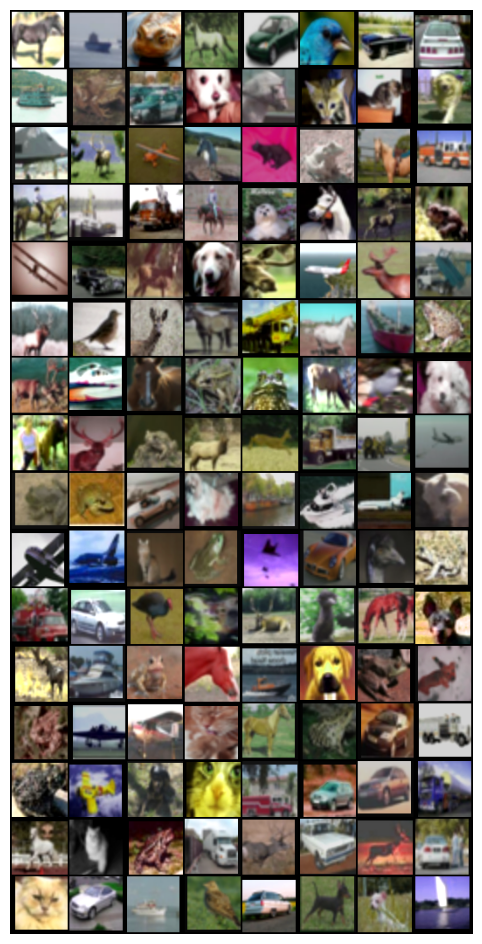

In [6]:
import matplotlib.pyplot as plt

# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W: np.ndarray = image_tensor.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 2: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C: np.ndarray = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 3: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row

# Show the grid
show_image(image_grid)

## Model — Encoder, Decoder, Classifier Head, SupervisedAE

In [7]:
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import MeanSquaredError

### Encoder

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 64, latent_noise_std: float = 0.0) -> None:
        """
        Convolutional encoder: compresses an image (B, 3, 64, 64) into a latent vector (B, latent_dim).
        """
        super().__init__()
        self.latent_noise_std = latent_noise_std

        # Input: (B, 3, 64, 64)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=32, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),  # -> (B, 32, 32, 32)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),  # -> (B, 64, 16, 16)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),  # -> (B, 128, 8, 8)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )

        # Extra layer for 64x64 inputs (down to 4x4)
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, 
                out_channels=128, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),  # -> (B, 128, 4, 4)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )

        # Flattened feature size after conv4: 128 × 4 × 4 = 2048
        self.flat_dim: int = 128 * 4 * 4

        # Fully connected (linear) layer: maps 2048 features → latent_dim
        # Performs: z = x @ W^T + b
        self.features_to_latent = nn.Linear(
            in_features=self.flat_dim,
            out_features=latent_dim,
            bias=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode a batch of images into latent features.
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten convolutional features: (B, 128, 4, 4) → (B, 2048)
        feat_flat = x.flatten(start_dim=1)

        # Linear projection: (B, 2048) → (B, latent_dim)
        z = self.features_to_latent(feat_flat)

        # Add Gaussian noise during training
        if self.training and self.latent_noise_std > 0.0:
            z = z + torch.randn_like(z) * self.latent_noise_std

        return z

In [9]:
# ------------------------------------------------------------
# Test the Encoder class with a random input
# ------------------------------------------------------------

# Create a batch of 8 random RGB images (like CIFAR-10 size: 3×64×64)
random_images = torch.rand(8, 3, 64, 64)

# Initialize the encoder
encoder = Encoder(latent_dim=64)

# Pass the images through the encoder to get latent vectors
latent_vectors = encoder(random_images)

# Print the shape of the output
print("Input batch shape:          ", random_images.shape)
print("Output latent vector shape: ", latent_vectors.shape)
print("Expected shape: (8, 64)  →  8 samples, each compressed into 64 features")


Input batch shape:           torch.Size([8, 3, 64, 64])
Output latent vector shape:  torch.Size([8, 64])
Expected shape: (8, 64)  →  8 samples, each compressed into 64 features


### Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 64) -> None:
        """
        Decoder: reconstructs an image (B, 3, 64, 64) from a latent vector (B, latent_dim).
        """
        super().__init__()

        # Flattened feature map size from the encoder: (128 × 4 × 4) = 2048
        self.flat_dim = 128 * 4 * 4

        # Fully connected (linear) layer: latent vector → flattened feature map
        # Performs: x = z @ W^T + b
        self.latent_to_features = nn.Linear(
            in_features=latent_dim,
            out_features=self.flat_dim,
            bias=True
        )

        self.decoder_cnn = nn.Sequential(

            # 4x4 → 8x8
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=64),
            nn.GELU(),

            # 8x8 → 16x16
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.GELU(),

            # 16x16 → 32x32
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=16),
            nn.GELU(),

            # 32x32 → 64x64 (final RGB image)
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True
            ),

            # Output pixel values normalized to [0, 1]
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode a latent vector into a reconstructed image.

        """
        # Linear projection: (B, latent_dim) → (B, 2048)
        x = self.latent_to_features(z)

        # Reshape flattened features into feature map (B, 128, 4, 4)
        x = x.view(z.size(0), 128, 4, 4)

        # Upsample step-by-step to full image size (B, 3, 64, 64)
        x_hat = self.decoder_cnn(x)

        return x_hat


In [11]:
# ------------------------------------------------------------
# Test the Decoder class with a random latent input
# ------------------------------------------------------------

# Create a batch of 8 random latent vectors (like output from the Encoder)
random_latents = torch.rand(8, 64)  # (B, latent_dim)

# Initialize the decoder
decoder = Decoder(latent_dim=64)

# Pass the latent vectors through the decoder to get reconstructed images
reconstructed_images = decoder(random_latents)

# Print the shape of the output
print("Input latent vector shape:    ", random_latents.shape)
print("Output reconstructed shape:   ", reconstructed_images.shape)
print("Expected shape: (8, 3, 64, 64)  →  8 images reconstructed from 64-D features")


Input latent vector shape:     torch.Size([8, 64])
Output reconstructed shape:    torch.Size([8, 3, 64, 64])
Expected shape: (8, 3, 64, 64)  →  8 images reconstructed from 64-D features


### Classifier

In [12]:
class ClassifierHead(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10, classifier_dropout: float = 0.0) -> None:
        """
        ClassifierHead: maps latent vectors (B, latent_dim) → class logits (B, num_classes).
        """
        super().__init__()

        # Hidden layer dimension — can be tuned for capacity (64, 128, 256)
        self.hidden_dim = 64

        # ------------------------------------------------------------
        # Simple MLP classifier: latent vector → hidden layer → logits
        # ------------------------------------------------------------
        self.mlp = nn.Sequential(

            # Fully connected layer: converts latent vector → hidden features
            nn.Linear(
                in_features=latent_dim,
                out_features=self.hidden_dim,
                bias=True
            ),

            # Normalize hidden features across the batch
            nn.BatchNorm1d(num_features=self.hidden_dim),

            # Apply non-linearity so the model can learn complex patterns
            nn.ReLU(inplace=True),

            # Randomly zero out some hidden units during training to prevent overfitting
            nn.Dropout(p=classifier_dropout),

            # Final layer: convert hidden features → class scores (logits)
            # (No softmax here — CrossEntropyLoss will handle it)
            nn.Linear(
                in_features=self.hidden_dim,
                out_features=num_classes,
                bias=True
            ),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: predict class logits from latent vectors.
        """
        logits = self.mlp(z)
        return logits

In [13]:
# ------------------------------------------------------------
# Test the ClassifierHead with random latent vectors
# ------------------------------------------------------------

# Create a batch of random latent vectors (like from the Encoder)
random_latents = torch.rand(8, 64)  # (B, latent_dim)

# Initialize the classifier head
classifier = ClassifierHead(latent_dim=64, num_classes=10, classifier_dropout=0.25)

# Pass the latent vectors through the classifier to get logits
logits = classifier(random_latents)

# Print the shapes for verification
print("Input latent shape: ", random_latents.shape)
print("Output logits shape:", logits.shape)
print("Expected shape: (8, 10)  →  8 samples, each with scores for 10 classes")



Input latent shape:  torch.Size([8, 64])
Output logits shape: torch.Size([8, 10])
Expected shape: (8, 10)  →  8 samples, each with scores for 10 classes


### Supervised autoencoder

In [14]:
class SupervisedAE(nn.Module):
    def __init__(
        self,
        latent_dim: int = 64,
        num_classes: int = 10,
        lambda_recon: float = 0.25,
        latent_noise_std: float = 0.0,
        classifier_dropout: float = 0.0
    ) -> None:
        """
        Supervised Autoencoder:
        Combines an Encoder, Decoder, and ClassifierHead into one model.
        """
        super().__init__()

        # Store hyperparameters
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.lambda_recon = lambda_recon
        self.latent_noise_std = latent_noise_std
        self.classifier_dropout = classifier_dropout

        # Step 1 — Define submodules

        # Encoder: image → latent vector
        self.encoder = Encoder(
            latent_dim=latent_dim,
            latent_noise_std=latent_noise_std
        )

        # Decoder: latent vector → reconstructed image
        self.decoder = Decoder(
            latent_dim=latent_dim
        )

        # Classifier: latent vector → class logits
        self.head = ClassifierHead(
            latent_dim=latent_dim,
            num_classes=num_classes,
            classifier_dropout=classifier_dropout
        )


    # Forward pass
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Run the full forward pass of the supervised autoencoder.

        """

        # Step 1 — Encode image to latent space
        z = self.encoder(x)

        # Step 2 — Decode latent back to image
        x_hat = self.decoder(z)

        # Step 3 — Predict class logits directly from latent representation
        logits = self.head(z)

        return z, x_hat, logits


In [15]:
# ------------------------------------------------------------
# Test the SupervisedAE (Encoder + Decoder + Classifier)
# ------------------------------------------------------------

# Create a batch of random RGB images (like CIFAR-10, 3×64×64)
random_images = torch.rand(8, 3, 64, 64)

# Initialize the Supervised Autoencoder
model = SupervisedAE(
    latent_dim=64,
    num_classes=10,
    lambda_recon=0.25,
    latent_noise_std=0.03,
    classifier_dropout=0.25
)

# Run a forward pass
z, x_hat, logits = model(random_images)

# Print output shapes for verification
print("Input batch shape:      ", random_images.shape)
print("Latent vector shape:    ", z.shape)
print("Reconstructed image:    ", x_hat.shape)
print("Class logits shape:     ", logits.shape)

print("\nExpected:")
print(" - Latent:        (8, 64)      → 8 samples, each 64-D encoded vector")
print(" - Reconstruction:(8, 3, 64, 64) → 8 decoded images")
print(" - Logits:        (8, 10)      → 8 samples, each with 10 class scores")


Input batch shape:       torch.Size([8, 3, 64, 64])
Latent vector shape:     torch.Size([8, 64])
Reconstructed image:     torch.Size([8, 3, 64, 64])
Class logits shape:      torch.Size([8, 10])

Expected:
 - Latent:        (8, 64)      → 8 samples, each 64-D encoded vector
 - Reconstruction:(8, 3, 64, 64) → 8 decoded images
 - Logits:        (8, 10)      → 8 samples, each with 10 class scores


## Loss functions

In [16]:
import torch.nn.functional as F

def reconstruction_loss(x_hat: torch.Tensor, x: torch.Tensor, loss_type: str = 'mse') -> torch.Tensor:
    """
    Compute reconstruction loss between model output and input.
    """
    if loss_type == 'mse':
        return F.mse_loss(x_hat, x)
    elif loss_type == 'bce':
        return F.binary_cross_entropy(x_hat, x)
    else:
        raise NotImplementedError(f"Loss type '{loss_type}' not implemented.")


def classification_loss(logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute classification loss using cross-entropy.
    """
    return F.cross_entropy(logits, y)


def total_loss(
    logits: torch.Tensor,
    x_hat: torch.Tensor,
    y: torch.Tensor,
    x: torch.Tensor,
    lambda_recon: float = 0.25,
    loss_type: str = 'mse'
) -> torch.Tensor:
    """
    Combine classification and reconstruction losses.
    """
    recon_loss = reconstruction_loss(x_hat, x, loss_type)
    cls_loss = classification_loss(logits, y)
    total = cls_loss + lambda_recon * recon_loss
    return total

# Training Loop

https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb

In [17]:
from torch.nn.utils import clip_grad_norm_
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.regression import MeanSquaredError


@torch.no_grad()
def evaluate(model: torch.nn.Module, loader: torch.utils.data.DataLoader, device: str, loss_type: str) -> dict[str, float]:
    """
    Evaluate model performance on a dataset (no gradient computation).
    Returns averaged loss, accuracy, and RMSE.
    """
    model.eval()
    acc = MulticlassAccuracy(num_classes=model.num_classes).to(device)
    rmse = MeanSquaredError(squared=False).to(device)
    tot_loss: float = 0.0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        _, x_hat, logits = model(X)
        loss = total_loss(logits, x_hat, y, X, model.lambda_recon, loss_type)
        tot_loss += loss.item()
        acc.update(logits, y)  # argmax handled internally
        rmse.update(x_hat, X)

    n: int = len(loader)
    return {
        "loss": tot_loss / n,
        "acc": acc.compute().item(),
        "rmse": rmse.compute().item(),
    }


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    n_epochs: int = 10,
    device: str | None = None,
    max_grad_norm: float = 1.0,
    scheduler_patience: int = 2,
    scheduler_factor: float = 0.5,
    loss_type: str = "mse"
) -> dict[str, list[float]]:
    """
    Train the supervised autoencoder.
    Tracks and returns loss, accuracy, and RMSE for train and validation.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    acc_tm = MulticlassAccuracy(num_classes=model.num_classes).to(device)
    rmse_tm = MeanSquaredError(squared=False).to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=scheduler_patience, factor=scheduler_factor
    )

    history: dict[str, list[float]] = {
        "train_loss": [], "train_acc": [], "train_rmse": [],
        "val_loss": [], "val_acc": [], "val_rmse": []
    }

    for epoch in range(1, n_epochs + 1):
        model.train()
        acc_tm.reset()
        rmse_tm.reset()
        running: float = 0.0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            z, x_hat, logits = model(X)

            # L1 regularization term (penalize large latent activations)
            l1_loss: torch.Tensor = 5e-2 * z.abs().mean()

            # Compute total supervised autoencoder loss
            loss: torch.Tensor = total_loss(logits, x_hat, y, X, model.lambda_recon, loss_type)

            # Add regularization
            loss = loss + l1_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            running += loss.item()
            acc_tm.update(logits, y)
            rmse_tm.update(x_hat, X)

        # ---- Training metrics
        train_loss: float = running / len(train_loader)
        train_acc: float = acc_tm.compute().item()
        train_rmse: float = rmse_tm.compute().item()

        # ---- Validation metrics
        val_metrics: dict[str, float] = evaluate(model, valid_loader, device, loss_type)
        scheduler.step(val_metrics["acc"])  # reduce LR on plateau of val accuracy

        # ---- Log metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_rmse"].append(val_metrics["rmse"])

        print(
            f"Epoch {epoch:02d}/{n_epochs} | "
            f"train: loss {train_loss:.4f}, acc {train_acc:.3f}, rmse {train_rmse:.4f} | "
            f"val: loss {val_metrics['loss']:.4f}, acc {val_metrics['acc']:.3f}, rmse {val_metrics['rmse']:.4f}"
        )

    return history

## Hyperparameters explorations

In [18]:
# # ==== Optuna hyperparameter search (single objective) ====
# # pip install optuna  # if not installed

# import optuna
# import torch


# # ---- choose target: "accuracy" (maximize) OR "val_rmse" (minimize) ----
# # selection_metric = "accuracy"   # or "val_rmse"
# selection_metric = "val_rmse"   # or "accuracy"
# direction = "maximize" if selection_metric == "accuracy" else "minimize"

# # ---- fewer epochs during search (speed-up) ----
# SEARCH_EPOCHS = min(10, CONFIG.get("epochs", 60))

# def objective(trial: optuna.Trial):
#     # --- search space ---
#     latent_dim       = trial.suggest_categorical("latent_dim", [32, 64, 128])
#     lambda_recon     = trial.suggest_float("lambda_recon", 0.05, 50, log=True) # 0.1, 0.25, 1, 5, 10, 50
#     latent_noise_std = trial.suggest_float("latent_noise_std", 0.0, 0.1)
#     lr               = trial.suggest_float("lr", 1e-4, 1e-3, log=True)

#     # --- model & optimizer ---
#     model = SupervisedAE(
#         latent_dim=latent_dim,
#         num_classes=CONFIG["num_classes"],
#         lambda_recon=lambda_recon,
#         latent_noise_std=latent_noise_std,
#     )
#     optimizer = torch.optim.NAdam(
#         model.parameters(),
#         lr=lr,
#         weight_decay=CONFIG.get("weight_decay", 0.0)
#     )

#     # --- train for SEARCH_EPOCHS ---
#     history = train(
#         model, optimizer,
#         train_loader, valid_loader,
#         n_epochs=SEARCH_EPOCHS,
#         loss_type=CONFIG.get("loss_type", "mse")
#     )

#     # --- take last-epoch validation metrics ---
#     last_val_acc  = float(history["val_acc"][-1])
#     last_val_rmse = float(history["val_rmse"][-1])

#     # log for inspection
#     trial.set_user_attr("val_acc", last_val_acc)
#     trial.set_user_attr("val_rmse", last_val_rmse)

#     # --- return the chosen metric ---
#     return last_val_acc if selection_metric == "accuracy" else last_val_rmse

# # ---- run Optuna ----
# study = optuna.create_study(direction=direction, sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=25, show_progress_bar=True)

# # ---- best trial info ----
# print("Best trial:")
# print("  value:", study.best_value)
# print("  params:", study.best_params)
# print("  val_acc:", study.best_trial.user_attrs.get("val_acc"))
# print("  val_rmse:", study.best_trial.user_attrs.get("val_rmse"))

In [19]:
# # ---- update CONFIG ----
# CONFIG["latent_dim"]       = int(study.best_params["latent_dim"])
# CONFIG["lambda_recon"]     = float(study.best_params["lambda_recon"])
# CONFIG["latent_noise_std"] = float(study.best_params["latent_noise_std"])
# CONFIG["lr"]               = float(study.best_params["lr"])

# print("\nCONFIG updated:")
# for k in ["latent_dim", "lambda_recon", "latent_noise_std", "lr"]:
#     print(f"  {k}: {CONFIG[k]}")

## Training model with (best) hyperparameters

In [20]:
# Create the model
ae_model: SupervisedAE = SupervisedAE(
    latent_dim=CONFIG["latent_dim"],
    num_classes=CONFIG["num_classes"],
    lambda_recon=CONFIG["lambda_recon"],
    latent_noise_std=CONFIG["latent_noise_std"],
    classifier_dropout=CONFIG["classifier_dropout"],
)

# Print model configuration / hyperparameters
print("\n[MODEL SETUP]")
print("-------------------------------------------")
print(f"Latent dimension         : {ae_model.latent_dim}")
print(f"Number of classes        : {ae_model.num_classes}")
print(f"lambda_recon (weight)    : {ae_model.lambda_recon}  <-- scales reconstruction loss")
print(f"Latent noise std         : {ae_model.latent_noise_std}")
print(f"Classifier dropout       : {ae_model.classifier_dropout}")
print("-------------------------------------------\n")

# Optimizer
optimizer: torch.optim.Optimizer = torch.optim.NAdam(
    ae_model.parameters(),
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"],
)

# Train the model
history: dict[str, list[float]] = train(
    model=ae_model,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    n_epochs=CONFIG["epochs"],
    loss_type=CONFIG["loss_type"],
)


[MODEL SETUP]
-------------------------------------------
Latent dimension         : 64
Number of classes        : 10
lambda_recon (weight)    : 50  <-- scales reconstruction loss
Latent noise std         : 0.03
Classifier dropout       : 0.25
-------------------------------------------

Epoch 01/40 | train: loss 3.2476, acc 0.398, rmse 0.1733 | val: loss 2.1347, acc 0.506, rmse 0.1205
Epoch 02/40 | train: loss 2.1005, acc 0.512, rmse 0.1168 | val: loss 1.7162, acc 0.586, rmse 0.1047
Epoch 03/40 | train: loss 1.8236, acc 0.573, rmse 0.1071 | val: loss 1.6058, acc 0.603, rmse 0.0986
Epoch 04/40 | train: loss 1.6519, acc 0.611, rmse 0.1010 | val: loss 1.5128, acc 0.646, rmse 0.1005
Epoch 05/40 | train: loss 1.5335, acc 0.644, rmse 0.0977 | val: loss 1.3199, acc 0.688, rmse 0.0936
Epoch 06/40 | train: loss 1.4406, acc 0.669, rmse 0.0953 | val: loss 1.2634, acc 0.711, rmse 0.0929
Epoch 07/40 | train: loss 1.3668, acc 0.689, rmse 0.0933 | val: loss 1.2214, acc 0.722, rmse 0.0910
Epoch 08/4

## Plot of accuracy, loss and rmse

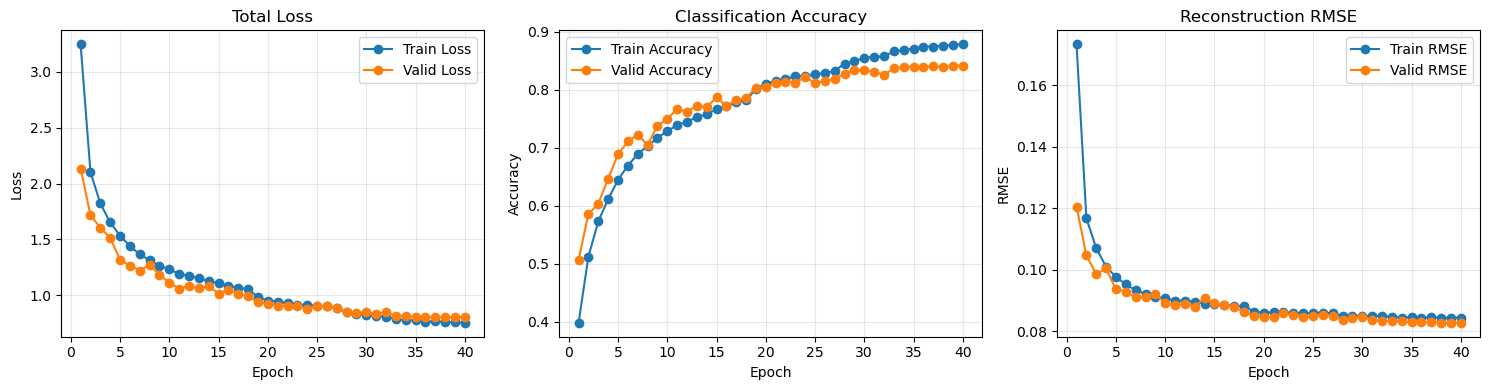

In [21]:
import matplotlib.pyplot as plt


def plot_training_history(history: dict[str, list[float]]) -> None:
    """
    Plot training vs validation curves for loss, accuracy, and RMSE.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 4))

    # ---- 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Valid Loss", marker="o")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- 2. Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Valid Accuracy", marker="o")
    plt.title("Classification Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- 3. RMSE
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_rmse"], label="Train RMSE", marker="o")
    plt.plot(epochs, history["val_rmse"], label="Valid RMSE", marker="o")
    plt.title("Reconstruction RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Example usage
plot_training_history(history)


# Evaluation

## Image reconstruction

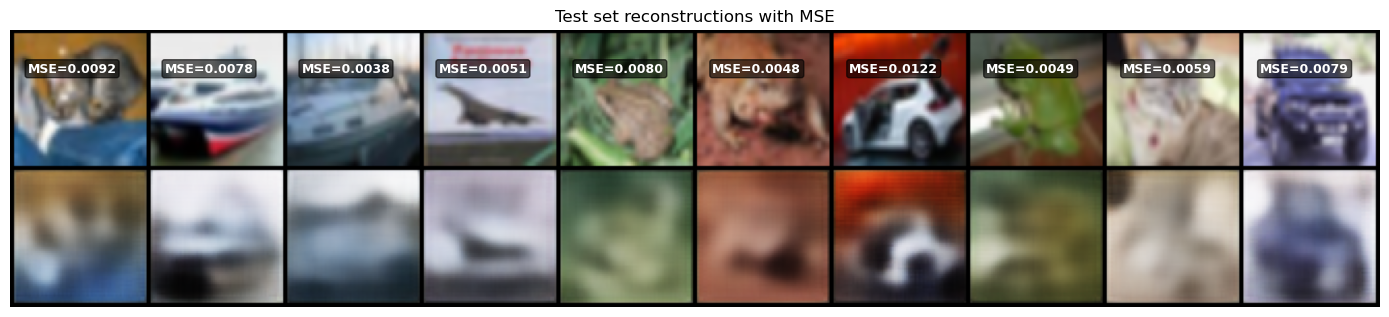

In [22]:
from torchvision.utils import make_grid

@torch.no_grad()
def show_reconstructions(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    n: int = 8,
    device: str | None = None,
    title: str = "Reconstructions with Errors"
) -> None:
    """
    Display original images (top) and their reconstructions (bottom)
    for n samples from the first batch, with per-image reconstruction
    errors (MSE) annotated above each column.
    """
    device = device or next(model.parameters()).device
    model.eval()

    # Get one mini-batch
    X, _ = next(iter(loader))
    X = X.to(device)[:n]

    # Forward pass
    _, X_hat, _ = model(X)

    # Compute per-sample MSE over pixels
    errors = F.mse_loss(X_hat, X, reduction="none")
    errors = errors.view(errors.size(0), -1).mean(dim=1).detach().cpu().numpy()

    # Combine originals and reconstructions into one grid (2 rows)
    both = torch.cat([X, X_hat.clamp(0, 1)], dim=0)
    grid = make_grid(both, nrow=n, padding=2)

    # Plot grid
    plt.figure(figsize=(1.8 * n, 3.6))
    plt.imshow(grid.permute(1, 2, 0).detach().cpu())
    plt.axis("off")
    plt.title(title)

    # Annotate with reconstruction error (MSE) above each column
    for i, err in enumerate(errors):
        plt.text(
            x=i * (grid.shape[2] / n) + 8,
            y=20,
            s=f"MSE={err:.4f}",
            color="white",
            fontsize=9,
            weight="bold",
            bbox=dict(facecolor="black", alpha=0.6, boxstyle="round,pad=0.2")
        )

    plt.show()


# Plot the reconstruction
show_reconstructions(ae_model, test_loader, n=10, title="Test set reconstructions with MSE")


## Classification report

In [23]:
from sklearn.metrics import classification_report

@torch.no_grad()
def evaluate_classification_report(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    class_names: list[str],
    device: str | None = None,
    digits: int = 3
) -> tuple[str, np.ndarray, np.ndarray]:
    """
    Evaluate the model and print a sklearn-style classification report.
    """
    device = device or next(model.parameters()).device
    model.eval()

    y_true, y_pred = [], []

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        _, _, logits = model(X)
        preds = logits.argmax(dim=1)
        y_true.append(y.cpu())
        y_pred.append(preds.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # Generate and print the report using known class names
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=digits,
        zero_division=0
    )

    print("\n[Classification Report]")
    print(report)

    return report, y_true, y_pred


report, y_true, y_pred = evaluate_classification_report(
    model=ae_model,
    loader=test_loader,
    class_names=cifar10_classes,
    device=device
)


[Classification Report]
              precision    recall  f1-score   support

    airplane      0.846     0.860     0.853      1000
  automobile      0.911     0.918     0.914      1000
        bird      0.811     0.736     0.772      1000
         cat      0.720     0.658     0.688      1000
        deer      0.806     0.824     0.815      1000
         dog      0.714     0.794     0.752      1000
        frog      0.858     0.885     0.871      1000
       horse      0.887     0.858     0.872      1000
        ship      0.909     0.914     0.911      1000
       truck      0.891     0.905     0.898      1000

    accuracy                          0.835     10000
   macro avg      0.835     0.835     0.835     10000
weighted avg      0.835     0.835     0.835     10000



## Confusion matrix

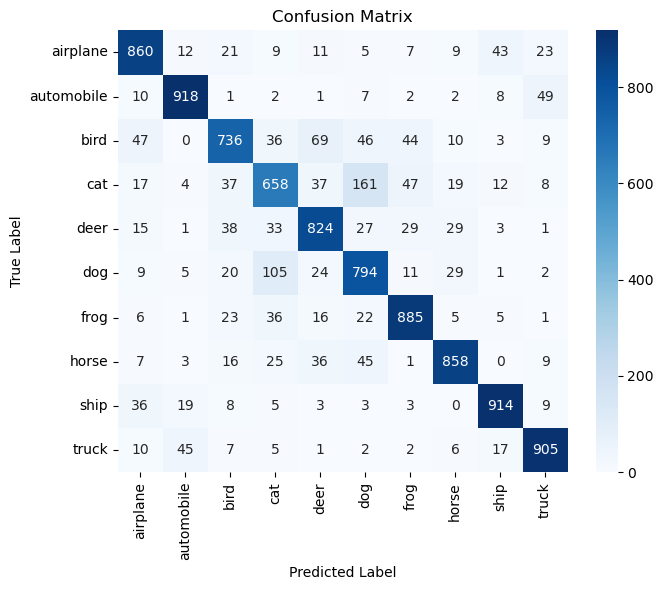

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: list[str],
    normalize: bool = False
) -> None:
    """
    Plot a clean confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# After getting y_true and y_pred from evaluation
plot_confusion_matrix(y_true, y_pred, class_names=cifar10_classes, normalize=False)

# 2D latent visualization
## TSNE

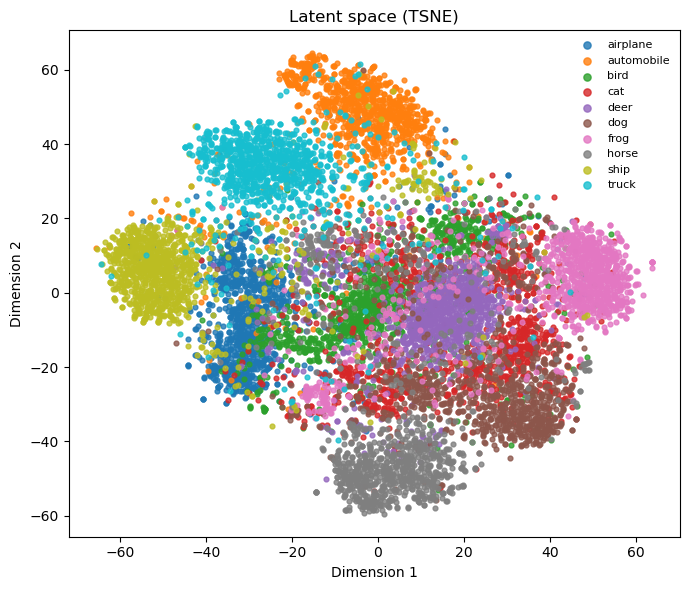

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Extract latents (z) and labels
@torch.no_grad()
def extract_latents(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: str | None = None
) -> tuple[torch.Tensor, torch.Tensor]:
    """Extract latent representations (z) and labels from a trained model."""
    device = device or next(model.parameters()).device
    model.eval()

    Z_list, y_list = [], []
    for X, y in loader:
        X = X.to(device)
        z, _, _ = model(X)
        Z_list.append(z.detach().cpu())
        y_list.append(y.detach().cpu())

    Z = torch.cat(Z_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return Z, y


# Reduce latents to 2D (PCA or t-SNE) and plot
def plot_latent_2d(
    Z: torch.Tensor | np.ndarray,
    y: torch.Tensor | np.ndarray,
    method: str,
    class_names: list[str]
) -> None:
    """Reduce latent vectors to 2D using PCA or t-SNE and visualize them."""
    Z = Z.detach().cpu().numpy() if hasattr(Z, "detach") else np.asarray(Z)
    y = y.detach().cpu().numpy() if hasattr(y, "detach") else np.asarray(y)

    # Reduce dimensionality
    if method.lower() == "pca":
        emb = PCA(n_components=2).fit_transform(Z)
    elif method.lower() == "tsne":
        emb = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(Z)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    # Scatter plot
    plt.figure(figsize=(7, 6))
    for cls in np.unique(y):
        mask = (y == cls)
        plt.scatter(emb[mask, 0], emb[mask, 1], s=12, alpha=0.8, label=class_names[cls])

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Latent space ({method.upper()})")
    plt.legend(markerscale=1.5, fontsize=8, loc="best", frameon=False)
    plt.tight_layout()
    plt.show()

Z, y = extract_latents(ae_model, test_loader)
plot_latent_2d(Z, y, method="tsne", class_names=cifar10_classes)

## PCA

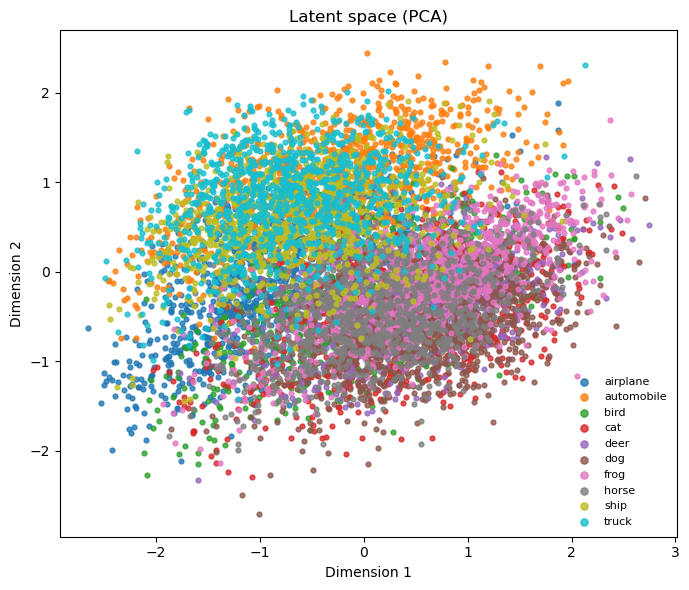

In [26]:
plot_latent_2d(Z, y, method="pca", class_names=cifar10_classes)

In [27]:
# TODO: add cumulative explained variance ratio

## Umap

In [28]:
# TODO: add umap plots

# Results interpretation